# Experimental Setup Level 1 - Simplest

I am setting up experiments in growing degree of compelxity and data volume.

## Level 1A)

* 1 building - site 1241
* 1 meter reading - meter 0
* Only historical meter readings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
from tsm.data_selector import data_subset_by_dict

In [4]:
import matplotlib.pyplot as plt

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
import numpy as np

In [7]:
train_data = pd.read_pickle('kaggle/input/ashrae-energy-prediction/train.pkl')

In [8]:
level_1a = {'building_id': 1241, 'meter': 0}
level_1a_cols = ['meter_reading', 'timestamp']

In [9]:
data_1a = data_subset_by_dict(train_data, level_1a, level_1a_cols)

In [19]:
# Missing values that are 0s
data_1a.iloc[-2000:,:].head(n=20)

,meter_reading,timestamp
15545953,0.0,2016-10-09 16:00:00
15548314,0.0,2016-10-09 17:00:00
15550676,0.0,2016-10-09 18:00:00
15553037,0.0,2016-10-09 19:00:00
15555397,0.0,2016-10-09 20:00:00
15557760,0.0,2016-10-09 21:00:00
15560120,0.0,2016-10-09 22:00:00
15562481,0.0,2016-10-09 23:00:00
15564842,0.0,2016-10-10 00:00:00
15567204,0.0,2016-10-10 01:00:00


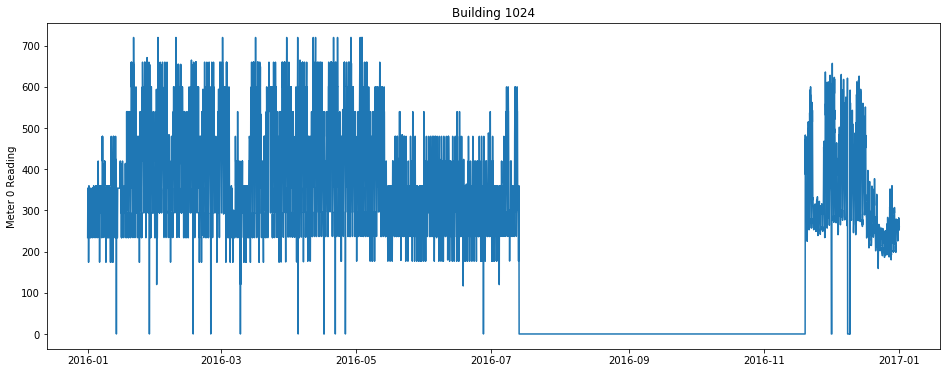

In [12]:
plt.figure(figsize=(16,6))
plt.title('Building 1024')
plt.ylabel('Meter 0 Reading')
plt.plot(data_1a.timestamp, data_1a.meter_reading)
plt.show()

We can see that:
1. There seems to be some kind of clear periodicity
2. There is a massive missing period between July and November

Let's look at autocorrelation and partial autocorrelation

In [15]:
import matplotlib as mpl

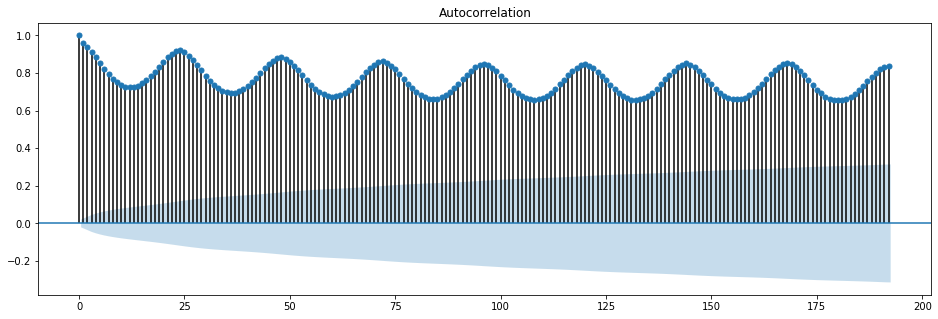

In [18]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(16, 5))
    plot_acf(data_1a.meter_reading, lags=24 * 8)
    plt.show()

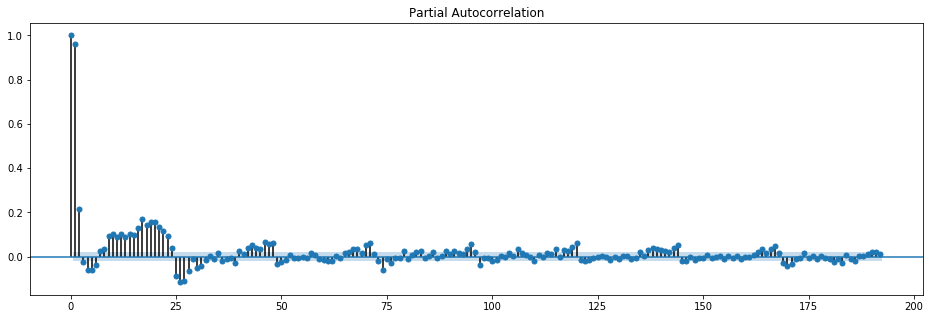

In [20]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(16, 5))
    plot_pacf(data_1a.meter_reading, lags=24*8)
    plt.show()

We can see that:
* Couple of hours before are strongly realated
* Same hour of the day, few days before is also quite correlated (24, 48, 72, 96 lags)
* Same weekday of previous week is not necessarily that much correlated

_Question_: Does the graph autocorellation graphs change drastically if we ignore the period with many missing values?

In [24]:
from datetime import datetime

In [25]:
prena_data_1a = data_1a[data_1a.timestamp < datetime(2019, 7, 10)]

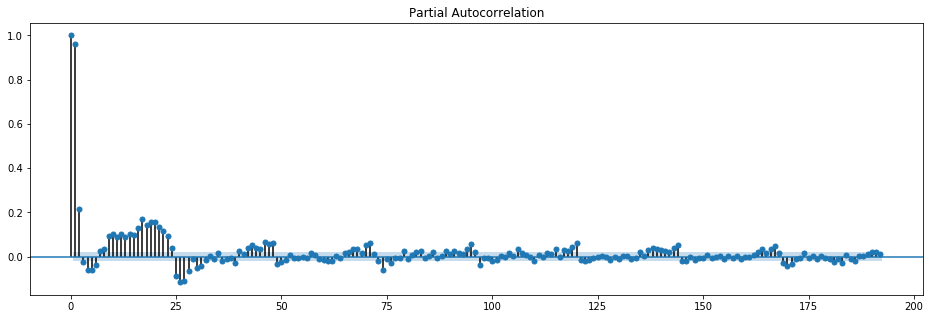

In [26]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(16, 5))
    plot_pacf(prena_data_1a.meter_reading, lags=24*8)
    plt.show()

**Answer**: seemingly no.

From the graph it seems that we should take lags in the folliwing way:
* Previous 24 hours
* Same hour and 2 hours before in the previous 7 days

But let us go gradually, and compute the accuracy of a dummy model that simply takes the mean of:
- 2 lags
- 4 lags
- 8 lags
- 16 lags
- 24 lags
- 32 lags

And only after having done this, let us take the same classifier with:
- best value of step before + 1 lag at same time for 2 days in the past
- best value of step before + 2 lag at same time for 2 days in the past
- best value of step before + 1 lag at same time for 4 days in the past
- best value of step before + 2 lag at same time for 4 days in the past
- best value of step before + 1 lag at same time for 7 days in the past
- best value of step before + 2 lag at same time for 7 days in the past
- best value of step before + 3 lag at same time for 7 days in the past

In [63]:
from tsm.data_selector import get_series_past_k_lags

In [72]:
from tsm.eval_metrics import root_mean_squared_log_error

In [86]:
for k in [2, 4, 8, 16, 24, 32, 64, 128, 256, 512]:
    y_hat = get_series_past_k_lags(data_1a['meter_reading'], k=k).mean(axis=1).values
    y_true = data_1a['meter_reading'].values
    print(f'Accuracy of {k} lags', root_mean_squared_log_error(y_hat, y_true))

Accuracy of 2 lags 0.3557148033037671
Accuracy of 4 lags 0.3894940146969531
Accuracy of 8 lags 0.45160677745750644
Accuracy of 16 lags 0.5221653768959282
Accuracy of 24 lags 0.5563501080075292
Accuracy of 32 lags 0.5850409792711783
Accuracy of 64 lags 0.6863183004629138
Accuracy of 128 lags 0.8232046199562024
Accuracy of 256 lags 1.0450739916215803
Accuracy of 512 lags 1.3768018337852421


## Level 1B)

* 1 building - site 1241
* 1 meter reading - meter 0
* dt_m', 'dt_w', 'dt_d', 'dt_hour', 'dt_day_week', 'dt_day_month', 'dt_week_month'

In [148]:
level_1b = {'building_id': 1241, 'meter': 0}
level_1b_cols = ['meter_reading', 'dt_m', 'dt_w', 'dt_d', 'dt_hour', 'dt_day_week', 'dt_day_month', 'dt_week_month']

In [149]:
data_1b = data_subset_by_dict(train_data, level_1b, level_1b_cols)

In [150]:
data_1b.head()

,meter_reading,dt_m,dt_w,dt_d,dt_hour,dt_day_week,dt_day_month,dt_week_month
1831,234.179993,1,53,1,0,4,1,1
4127,294.156006,1,53,1,1,4,1,1
6423,354.152008,1,53,1,2,4,1,1
8722,294.121002,1,53,1,3,4,1,1
11017,294.101990,1,53,1,4,4,1,1


In [180]:
from tsm.data_utils import train_dev_test_split, df_to_x_y

In [178]:
data_1b_tr, data_1b_ts = train_dev_test_split(data_1b, train_pct=0.75, dev_pct=0)

In [182]:
_1b_dx = [x for x in range(1, len(list(data_1b)))]
_1b_dy = 0

In [185]:
_1b_tr_x, _1b_tr_y = df_to_x_y(data_1b_tr, _1b_dx, _1b_dy)
_1b_ts_x, _1b_ts_y = df_to_x_y(data_1b_ts, _1b_dx, _1b_dy)

In [186]:
from sklearn.ensemble import RandomForestRegressor

In [196]:
rfr = RandomForestRegressor(max_depth=15, n_jobs=-1, n_estimators=39)

In [197]:
rfr.fit(_1b_tr_x, _1b_tr_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [198]:
rfr_y = rfr.predict(_1b_ts_x)

In [199]:
root_mean_squared_log_error(rfr_y, _1b_ts_y)

3.879636346635983

### Adding waves

In [200]:
from tsm.data_utils import ordinal2wave

In [201]:
data_1b.head()

,meter_reading,dt_m,dt_w,dt_d,dt_hour,dt_day_week,dt_day_month,dt_week_month
1831,234.179993,1,53,1,0,4,1,1
4127,294.156006,1,53,1,1,4,1,1
6423,354.152008,1,53,1,2,4,1,1
8722,294.121002,1,53,1,3,4,1,1
11017,294.101990,1,53,1,4,4,1,1


In [202]:
ordinal2wave('dt_m', data_1b)
ordinal2wave('dt_w', data_1b)
ordinal2wave('dt_d', data_1b)
ordinal2wave('dt_hour', data_1b)
ordinal2wave('dt_day_week', data_1b)
ordinal2wave('dt_day_month', data_1b)
ordinal2wave('dt_week_month', data_1b)

In [203]:
data_1b.head()

,meter_reading,dt_m,dt_w,dt_d,dt_hour,dt_day_week,dt_day_month,dt_week_month,dt_m_sin,dt_m_cos,...,dt_d_sin,dt_d_cos,dt_hour_sin,dt_hour_cos,dt_day_week_sin,dt_day_week_cos,dt_day_month_sin,dt_day_month_cos,dt_week_month_sin,dt_week_month_cos
1831,234.179993,1,53,1,0,4,1,1,0.5,0.866025,...,0.017166,0.999853,0.000000,1.000000,-0.866025,-0.5,0.201299,0.97953,0.951057,0.309017
4127,294.156006,1,53,1,1,4,1,1,0.5,0.866025,...,0.017166,0.999853,0.269797,0.962917,-0.866025,-0.5,0.201299,0.97953,0.951057,0.309017
6423,354.152008,1,53,1,2,4,1,1,0.5,0.866025,...,0.017166,0.999853,0.519584,0.854419,-0.866025,-0.5,0.201299,0.97953,0.951057,0.309017
8722,294.121002,1,53,1,3,4,1,1,0.5,0.866025,...,0.017166,0.999853,0.730836,0.682553,-0.866025,-0.5,0.201299,0.97953,0.951057,0.309017
11017,294.101990,1,53,1,4,4,1,1,0.5,0.866025,...,0.017166,0.999853,0.887885,0.460065,-0.866025,-0.5,0.201299,0.97953,0.951057,0.309017


In [204]:
data_1b_tr, data_1b_ts = train_dev_test_split(data_1b, train_pct=0.75, dev_pct=0)

In [205]:
_1b_dx = [x for x in range(1, len(list(data_1b)))]
_1b_dy = 0

In [206]:
_1b_tr_x, _1b_tr_y = df_to_x_y(data_1b_tr, _1b_dx, _1b_dy)
_1b_ts_x, _1b_ts_y = df_to_x_y(data_1b_ts, _1b_dx, _1b_dy)

In [207]:
rfr = RandomForestRegressor(max_depth=15, n_jobs=-1, n_estimators=39)

In [208]:
rfr.fit(_1b_tr_x, _1b_tr_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [209]:
rfr_y = rfr.predict(_1b_ts_x)

In [210]:
root_mean_squared_log_error(rfr_y, _1b_ts_y)

3.3091377161619735

## Level 1C)

* 1 building - site 1241
* Look at other meter readings

In [20]:
level_1c_1 = {'building_id': 1241, 'meter': 1}
level_1c_2 = {'building_id': 1241, 'meter': 2}
level_1c_3 = {'building_id': 1241, 'meter': 3}
level_1c_cols = ['meter_reading', 'timestamp']

In [21]:
data_1c1 = data_subset_by_dict(train_data, level_1c_1, level_1c_cols)
data_1c2 = data_subset_by_dict(train_data, level_1c_2, level_1c_cols)
data_1c3 = data_subset_by_dict(train_data, level_1c_3, level_1c_cols)

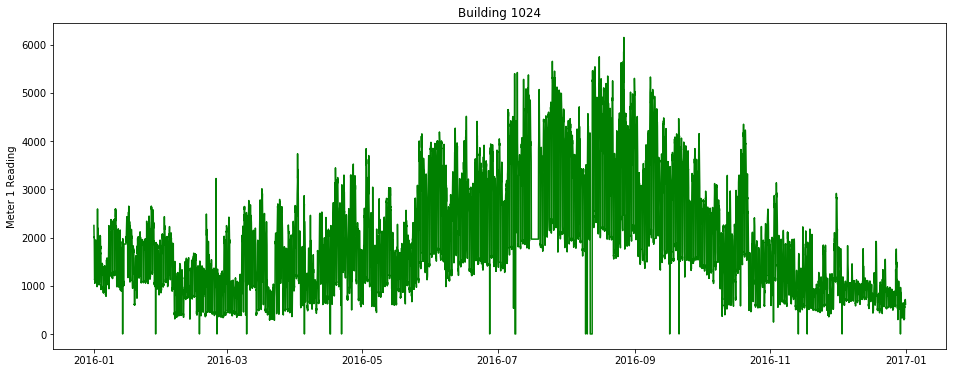

In [174]:
plt.figure(figsize=(16,6))
plt.title('Building 1024')
plt.ylabel('Meter 1 Reading')
plt.plot(data_1c1.timestamp, data_1c1.meter_reading, color='green')
plt.show()

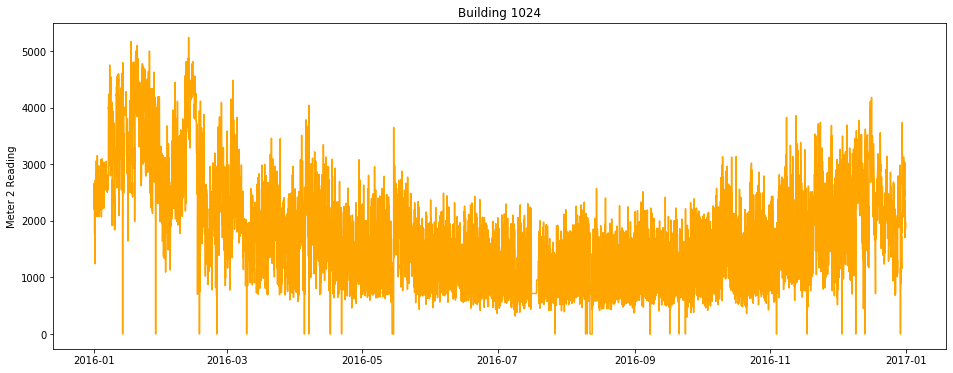

In [175]:
plt.figure(figsize=(16,6))
plt.title('Building 1024')
plt.ylabel('Meter 2 Reading')
plt.plot(data_1c2.timestamp, data_1c2.meter_reading, color='orange')
plt.show()

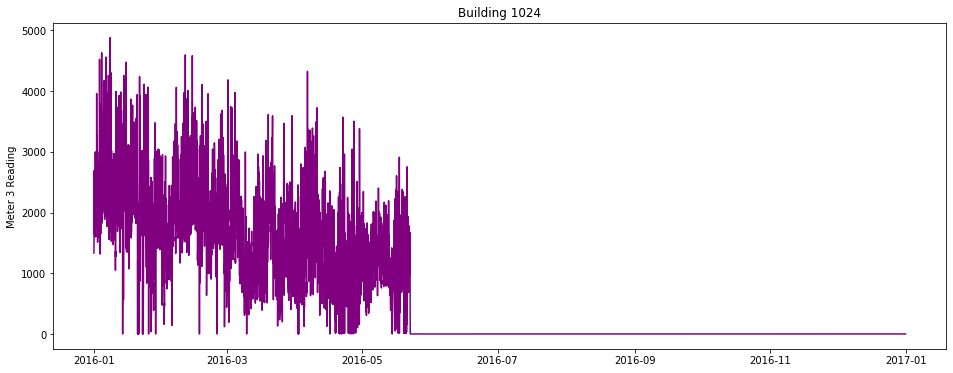

In [173]:
plt.figure(figsize=(16,6))
plt.title('Building 1024')
plt.ylabel('Meter 3 Reading')
plt.plot(data_1c3.timestamp, data_1c3.meter_reading, color='purple')
plt.show()

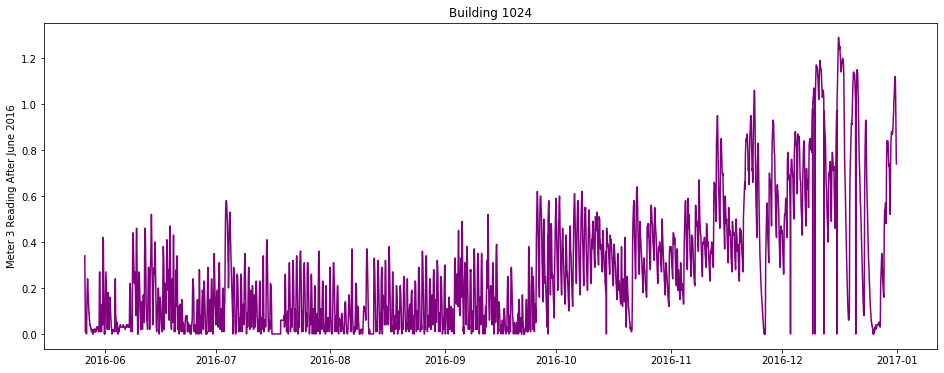

In [26]:
# Note the axis!
plt.figure(figsize=(16,6))
plt.title('Building 1024')
plt.ylabel('Meter 3 Reading After June 2016')
plt.plot(data_1c3.iloc[3500:].timestamp, data_1c3.iloc[3500:].meter_reading, color='purple')
plt.show()